In [1]:
# Import necessary packages and datasets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
df = pd.read_csv("./data/weather_with_avg_hourly_flight_delay.csv")
delay = df.copy()
delay.head()

DATE  HourlyAltimeterSetting  HourlyDewPointTemperature  \
0  2017-12-01T00:53:00                   30.14                       40.0   
1  2017-12-01T05:53:00                   30.08                       36.0   
2  2017-12-01T06:53:00                   30.07                       35.0   
3  2017-12-01T07:53:00                   30.06                       36.0   
4  2017-12-01T08:53:00                   30.06                       36.0   

   HourlyDryBulbTemperature  HourlySeaLevelPressure  HourlyStationPressure  \
0                      45.0                   30.16                  29.67   
1                      42.0                   30.10                  29.61   
2                      39.0                   30.09                  29.60   
3                      41.0                   30.09                  29.59   
4                      42.0                   30.08                  29.59   

   HourlyPressureChange  HourlyPressureTendency  HourlyVisibility  \
0                 -0.00                     3.0              10.0   
1                  0.00                     0.0              10.0   
2                  0.04                     6.0              10.0   
3                  0.00                     0.0              10.0   
4                  0.00                     0.0              10.0   

   HourlyWindSpeed          ...          REPORT_TYPE  cloud_1  cloud_0  \
0             13.0          ...                FM-15        0        1   
1             10.0          ...                FM-15        0        1   
2              8.0          ...                FM-15        0        1   
3              7.0          ...                FM-15        1        0   
4              9.0          ...                FM-15        0        1   

   wind_north  wind_east wind_south  wind_west   join_time  avg_delay  \
0           0          0          1          0  2017120100  -6.250000   
1           0          0          1          0  2017120105  -3.461538   
2           0          0          1          0  2017120106  -5.142857   
3           0          0          1          0  2017120107  10.714286   
4           0          0          1          0  2017120108   4.615385   

   actual_weather_delay  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  

[5 rows x 25 columns]

In [2]:
# Drop the columns in the dataset that has nothing to do with delay
delay.drop(['HourlySkyConditions', 'REPORT_TYPE', 'join_time', 'actual_weather_delay'], axis=1, inplace=True)


In [3]:
delay.head()

DATE  HourlyAltimeterSetting  HourlyDewPointTemperature  \
0  2017-12-01T00:53:00                   30.14                       40.0   
1  2017-12-01T05:53:00                   30.08                       36.0   
2  2017-12-01T06:53:00                   30.07                       35.0   
3  2017-12-01T07:53:00                   30.06                       36.0   
4  2017-12-01T08:53:00                   30.06                       36.0   

   HourlyDryBulbTemperature  HourlySeaLevelPressure  HourlyStationPressure  \
0                      45.0                   30.16                  29.67   
1                      42.0                   30.10                  29.61   
2                      39.0                   30.09                  29.60   
3                      41.0                   30.09                  29.59   
4                      42.0                   30.08                  29.59   

   HourlyPressureChange  HourlyPressureTendency  HourlyVisibility  \
0                 -0.00                     3.0              10.0   
1                  0.00                     0.0              10.0   
2                  0.04                     6.0              10.0   
3                  0.00                     0.0              10.0   
4                  0.00                     0.0              10.0   

   HourlyWindSpeed    ...      HourlyWetBulbTemperature  HourlyWindDirection  \
0             13.0    ...                          43.0                200.0   
1             10.0    ...                          39.0                210.0   
2              8.0    ...                          37.0                160.0   
3              7.0    ...                          39.0                160.0   
4              9.0    ...                          39.0                140.0   

   HourlyRelativeHumidity  cloud_1  cloud_0  wind_north  wind_east  \
0                    83.0        0        1           0          0   
1                    79.0        0        1           0          0   
2                    86.0        0        1           0          0   
3                    82.0        1        0           0          0   
4                    79.0        0        1           0          0   

   wind_south  wind_west  avg_delay  
0           1          0  -6.250000  
1           1          0  -3.461538  
2           1          0  -5.142857  
3           1          0  10.714286  
4           1          0   4.615385  

[5 rows x 21 columns]

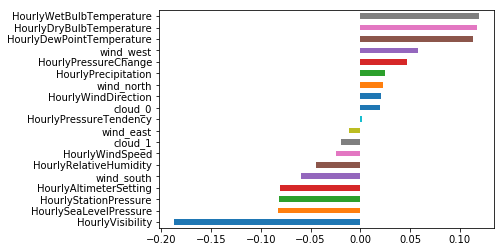

In [4]:
# Check the correlation
delay_corr = delay.corr()
(delay_corr
     .avg_delay
     .drop("avg_delay")
     .sort_values()
     .plot
     .barh())

In [5]:
import seaborn as sns

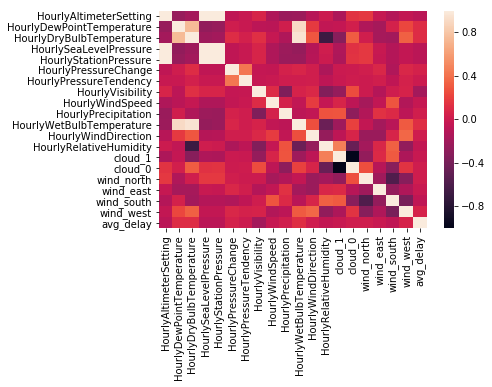

In [6]:
corr_heat = sns.heatmap(delay_corr)

In [7]:
# Drop date column
delay.drop("DATE", axis=1, inplace=True)

In [8]:
# Forward selection function to decide the best model
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model


model = forward_selected(delay, 'avg_delay')

print (model.model.formula)
# sl ~ rk + yr + 1

print (model.rsquared_adj)

avg_delay ~ HourlyVisibility + HourlyDryBulbTemperature + HourlyAltimeterSetting + HourlySeaLevelPressure + HourlyPrecipitation + cloud_0 + wind_south + HourlyPressureChange + HourlyPressureTendency + wind_east + HourlyDewPointTemperature + HourlyRelativeHumidity + HourlyWetBulbTemperature + cloud_1 + 1
0.06614465896824007


In [9]:
# Conduct a linear regression
formula = 'avg_delay ~ HourlyVisibility + HourlyDryBulbTemperature + HourlyRelativeHumidity + HourlyAltimeterSetting + HourlySeaLevelPressure + HourlyPrecipitation + wind_south + HourlyDewPointTemperature + HourlyWetBulbTemperature + wind_north + HourlyStationPressure + HourlyWindSpeed + 1'
avg = smf.ols(formula= formula,data=delay).fit()
avg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              avg_delay   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     44.07
Date:                Wed, 13 Mar 2019   Prob (F-statistic):          8.84e-102
Time:                        01:21:22   Log-Likelihood:                -29998.
No. Observations:                7465   AIC:                         6.002e+04
Df Residuals:                    7452   BIC:                         6.011e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   184.1759     27.841      6.615      0.000     129.600     238.752
HourlyVisibility             -1.5235      0.088    -17.350      0.000      -1.696      -1.351
HourlyDryBulbTemperature      0.2560      0.137      1.871      0.061      -0.012       0.524
HourlyRelativeHumidity       -0.2532      0.055     -4.592      0.000      -0.361      -0.145
HourlyAltimeterSetting     -157.8693     62.901     -2.510      0.012    -281.173     -34.565
HourlySeaLevelPressure      148.6243     33.922      4.381      0.000      82.127     215.122
HourlyPrecipitation         -29.3731      9.503     -3.091      0.002     -48.002     -10.744
wind_south                   -0.7011      0.425     -1.648      0.099      -1.535       0.133
HourlyDewPointTemperature     1.1699      0.223      5.237      0.000       0.732       1.608
HourlyWetBulbTemperature     -1.3019      0.309     -4.216      0.000      -1.907      -0.697
wind_north                    0.2165      0.418      0.517      0.605      -0.604       1.037
HourlyStationPressure         4.3149     54.233      0.080      0.937    -101.997     110.627
HourlyWindSpeed               0.0129      0.038      0.337      0.736      -0.062       0.088
==============================================================================
Omnibus:                     7652.847   Durbin-Watson:                   1.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           718689.492
Skew:                           4.940   Prob(JB):                         0.00
Kurtosis:                      50.042   Cond. No.                     6.38e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
# Make predictions
p1 = avg.predict(delay)
delay["p1"] = p1

In [11]:
plt.figure(figsize = (250, 100))
delay.p1.plot(label="Predictions", fontsize = 200)
delay.avg_delay.plot(label="Actual")

plt.suptitle("Linear Predicted Delay vs. Actual average delay", fontsize = 200)
plt.legend(fontsize = 200)
plt.show()

C:\Users\liang\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\liang\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


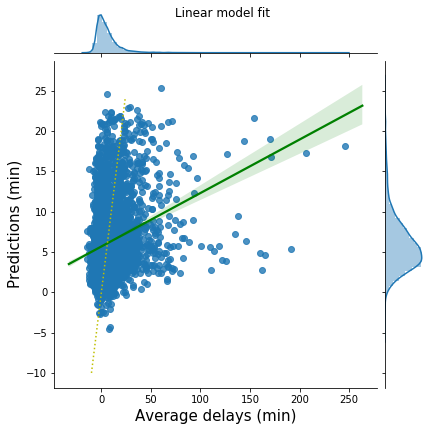

In [12]:
# Draw a fit plot using seaborn
sns.jointplot(x="avg_delay", y="p1", data=delay, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'green'}}, kind='reg')
plt.xlabel('Average delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.suptitle("Linear model fit")
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'y')

In [13]:
from sklearn.metrics import mean_absolute_error

In [14]:
# Calculate the mean absolute error
mean_absolute_error(delay.p1, delay.avg_delay)

8.045889106661978

In [15]:
from sklearn.metrics import mean_squared_error

In [16]:
# Calculate the mean squared error
mean_squared_error(delay.p1, delay.avg_delay)

181.0913630490846

In [17]:
delay.avg_delay[0]

-6.25

In [18]:
# Calculate the percentage of flights that falls within 15 mins interval centered at 15 minutes interval
count = 0
for i in range(len(delay.avg_delay)):
    if abs(delay.avg_delay[i]-p1[i]) > 15: count += 1
'{:.2f}%'.format(100 - count / len(p1) * 100)

'90.73%'